In [ ]:
## Add imports here
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
VOCAB_SIZE = 10000

def initialise_projections(d_model):
    """
    create projections for Q, K, V.
    """
    W_q = nn.Linear(d_model, d_model, bias=False)
    W_k = nn.Linear(d_model, d_model, bias=False)
    W_v = nn.Linear(d_model, d_model, bias=False)

    return W_q, W_k, W_v

def pairwise_similarities(q, k):
    """
    Compute dot product attention.
    """
    return torch.bmm(q, k.transpose(1, 2))
    
def attention_scaled(dot_prod):
    """
    Scale the raw attention scores.
    """
    return dot_prod / math.sqrt(dot_prod.size(-1))
    
def attention_softmax(attention_scores):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return F.softmax(attention_scores, dim=-1)

def compute_outputs(values, attention_weights):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.bmm(attention_weights, values)

def make_causal_mask(seq_len):
    """
    Create a mask matrix that masks future context for the attention.
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).to(DEVICE)
    mask = mask.masked_fill(mask == 1, float("-inf"))
    return mask

def apply_causal_mask(attention_scores, mask):
    """
    Apply mask to attention.
    """
    attention_scores = attention_scores + mask
    return attention_scores

def split_heads(input_tensor, num_heads):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_len, d_model = input_tensor.size()
    d_head = d_model // num_heads

    input_tensor = input_tensor.view(batch_size, seq_len, num_heads, d_head)
    input_tensor = input_tensor.transpose(1, 2)

    return input_tensor.contiguous().view(batch_size * num_heads, seq_len, d_head)

def merge_heads(output_tensor, num_heads):
    """
    Reversing splitting action of function split_heads().
    """
    batch_size_times_heads, seq_len, d_head = output_tensor.size()
    batch_size = batch_size_times_heads // num_heads
    d_model = d_head * num_heads

    output_tensor = output_tensor.view(batch_size, num_heads, seq_len, d_head)
    output_tensor = output_tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

    return output_tensor

def self_attention(attention_scores, values):
    """
    Self-attention block.
    """
    attention_weights = attention_softmax(attention_scores)
    output = compute_outputs(values, attention_weights)
    return output, attention_weights

def split_heads_qkv(q, k, v, num_heads):
    """
    Split Q, K, V across multiple heads.
    """
    q = split_heads(q, num_heads)
    k = split_heads(k, num_heads)
    v = split_heads(v, num_heads)

    return q, k, v

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        tokens_tensor = torch.tensor(tokens, dtype=torch.long)
        return tokens_tensor

def load_and_preprocess_data():
    with open("/kaggle/input/shakesphere/shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("/kaggle/input/shakesphere/shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()
    # with open("shakespear_test.txt", "r") as f:
    #     lines_test = f.readlines()

    tokens_train = [line.split() for line in lines_train]

    # Utility function to flatten tokens
    def flat(tokens):
        return [item for sublist in tokens for item in sublist]

    token_counts = Counter(flat(tokens_train))

    ## Create tokenizer
    tokenizer = {
        "<PAD>": 0,
        "<START>": 1,
        "<STOP>": 2,
        "<UNK>": 3,
    }

    tokenizer.update({token: i + 4 for i, (token, _) in enumerate(token_counts.most_common(VOCAB_SIZE - 4))})

    ## Create inverse tokenizer for decoding
    tokenizer_inv = {v: k for k, v in tokenizer.items()}

    ## Prepare datasets
    data_train = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines_train]
    data_val = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines_dev]

    ## Create input-output pairs
    train_dataset = TextDataset(data_train, tokenizer)
    val_dataset = TextDataset(data_val, tokenizer)

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    tokens = tokens[:max_len]
    if len(tokens) < max_len:
        tokens += [tokenizer["<PAD>"]] * (max_len - len(tokens))
    return tokens

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    tokens = [tokenizer.get(token, tokenizer["<UNK>"]) for token in sentence.split()]
    if include_stop:
        tokens.append(tokenizer["<STOP>"])
    if pad_to_len:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer)
    return tokens
    

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    tokens = [token for token in tokens if not(omit_pad and token == 0)]

    if end_at_stop and 2 in tokens:
        stop_index = tokens.index(2)
        tokens = tokens[:stop_index]

    return " ".join([tokenizer_inv.get(token, "<UNK>") for token in tokens])

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=0.6):
    """
    Generate a fixed number of tokens using the trained model.
    """
    ## Tokenize the context
    context = tokenize(context, pad_to_len=MAX_LEN, tokenizer=tokenizer, include_stop=False)
    context = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            ## Get predictions
            logits, _ = model(context)

            ## Focus on the last token's predictions
            last_logits = logits[:, -1, :].squeeze(1)

            ## Apply softmax to get probabilities
            probs = F.softmax(last_logits / temperature, dim=-1)

            ## Sample from the distribution
            next_token = torch.multinomial(probs, num_samples=1).item()

            ## Append to the context
            context = torch.cat([context, torch.tensor([[next_token]], dtype=torch.long).to(DEVICE)], dim=1)

            ## Stop if we generated a STOP token
            if next_token == tokenizer["<STOP>"]:
                break
         

    ## Convert back to text
    generated_text = decode(context.squeeze(0).cpu().numpy(), tokenizer_inv, end_at_stop=True, omit_pad=True)
    return generated_text

TransformerLM(
  (embedding): Embedding(10000, 512)
  (positional_encoding): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding_dropout): Dropout(p=0.05, inplace=False)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout

100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 1: Train Loss = 6.449590741134271, Val Loss = 5.9521207053486895
Sample text: <START> I still have to gentlewoman old that that all . . . . and you ,


100%|██████████| 41/41 [00:05<00:00,  7.18it/s]



Test perplexity: 393.22207682394793


100%|██████████| 82/82 [00:16<00:00,  4.98it/s]


Epoch 2: Train Loss = 5.854747940854328, Val Loss = 5.408266904877453
Sample text: <START> I still have to rather ward <UNK> ' sedges <UNK> , flouts Verona : is 'Bless And <UNK> <UNK> sup <UNK> as shrewd themselves


100%|██████████| 41/41 [00:05<00:00,  7.42it/s]



Test perplexity: 228.72067258737164


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 3: Train Loss = 5.417909965282533, Val Loss = 5.026581767128735
Sample text: <START> I still have to grows <UNK> , There It if and lord


100%|██████████| 41/41 [00:05<00:00,  7.57it/s]



Test perplexity: 145.88753182816424


100%|██████████| 82/82 [00:15<00:00,  5.14it/s]


Epoch 4: Train Loss = 5.182070261094628, Val Loss = 4.846870768360976
Sample text: <START> I still have to walk <UNK> gentleman


100%|██████████| 41/41 [00:05<00:00,  7.42it/s]



Test perplexity: 86.43964746425438


100%|██████████| 82/82 [00:16<00:00,  5.08it/s]


Epoch 5: Train Loss = 5.078812180495843, Val Loss = 4.756257298516064
Sample text: <START> I still have to <UNK> treats <UNK> desired well Pisa come .


100%|██████████| 41/41 [00:05<00:00,  7.44it/s]



Test perplexity: 82.9832039867572


100%|██████████| 82/82 [00:16<00:00,  5.11it/s]


Epoch 6: Train Loss = 5.018809527885623, Val Loss = 4.7036102254216265
Sample text: <START> I still have to they <UNK> <UNK> dew hardly name


100%|██████████| 41/41 [00:05<00:00,  7.52it/s]



Test perplexity: 82.58351990364514


100%|██████████| 82/82 [00:15<00:00,  5.14it/s]


Epoch 7: Train Loss = 4.989222410248547, Val Loss = 4.671338191846522
Sample text: <START> I still have to <UNK> meddling closely <UNK> <UNK> disguiser


100%|██████████| 41/41 [00:05<00:00,  7.49it/s]



Test perplexity: 73.92442072478656


100%|██████████| 82/82 [00:16<00:00,  5.10it/s]


Epoch 8: Train Loss = 4.968824008616005, Val Loss = 4.695781364673522
Sample text: <START> I still have to <UNK> <UNK> untrussing : Well Just


100%|██████████| 41/41 [00:05<00:00,  7.48it/s]



Test perplexity: 77.76564785271493


100%|██████████| 82/82 [00:16<00:00,  5.11it/s]


Epoch 9: Train Loss = 4.9525976762539, Val Loss = 4.702176852924068
Sample text: <START> I still have to So must in slender , Signior


100%|██████████| 41/41 [00:05<00:00,  7.51it/s]



Test perplexity: 73.6922111304166


100%|██████████| 82/82 [00:16<00:00,  5.11it/s]


Epoch 10: Train Loss = 4.926301898025885, Val Loss = 4.6407804779890105
Sample text: <START> I still have to <UNK> Anne to know talk to curst


100%|██████████| 41/41 [00:05<00:00,  7.53it/s]



Test perplexity: 68.88874648219529


100%|██████████| 82/82 [00:15<00:00,  5.13it/s]


Epoch 11: Train Loss = 4.903361442612439, Val Loss = 4.599722693606121
Sample text: <START> I still have to Such That hath reap and I have have give your <UNK> <UNK> reckoning for the lord , And upon him


100%|██████████| 41/41 [00:05<00:00,  7.52it/s]



Test perplexity: 66.71637260930785


100%|██████████| 82/82 [00:16<00:00,  5.12it/s]


Epoch 12: Train Loss = 4.874110309089103, Val Loss = 4.550834271965957
Sample text: <START> I still have to both judge : I am not will <UNK> <UNK> ale !


100%|██████████| 41/41 [00:05<00:00,  7.49it/s]



Test perplexity: 65.2572738633755


100%|██████████| 82/82 [00:16<00:00,  5.10it/s]


Epoch 13: Train Loss = 4.823257751581146, Val Loss = 4.515569654906669
Sample text: <START> I still have to should he hath he shall am am continue looker 's grace


100%|██████████| 41/41 [00:05<00:00,  7.47it/s]



Test perplexity: 62.5146401967929


100%|██████████| 82/82 [00:16<00:00,  5.10it/s]


Epoch 14: Train Loss = 4.800859410588334, Val Loss = 4.508725291345177
Sample text: <START> I still have to ; and , and sirrah


100%|██████████| 41/41 [00:05<00:00,  7.49it/s]



Test perplexity: 62.88702623446076


100%|██████████| 82/82 [00:16<00:00,  5.11it/s]


Epoch 15: Train Loss = 4.7636017101566965, Val Loss = 4.436941463772843
Sample text: <START> I still have to <UNK> discontent


100%|██████████| 41/41 [00:05<00:00,  7.51it/s]



Test perplexity: 59.14571616731217


100%|██████████| 82/82 [00:16<00:00,  5.12it/s]


Epoch 16: Train Loss = 4.722620871008896, Val Loss = 4.418627061494967
Sample text: <START> I still have to preparation


100%|██████████| 41/41 [00:05<00:00,  7.51it/s]



Test perplexity: 57.69489711309424


100%|██████████| 82/82 [00:16<00:00,  5.11it/s]


Epoch 17: Train Loss = 4.715513764358148, Val Loss = 4.35996394913371
Sample text: <START> I still have to and shall would know it is not from her ; And my life ; And so well are as sweet


100%|██████████| 41/41 [00:05<00:00,  7.54it/s]



Test perplexity: 55.082034529048265


100%|██████████| 82/82 [00:16<00:00,  5.12it/s]


Epoch 18: Train Loss = 4.6574910006872035, Val Loss = 4.337763489746466
Sample text: <START> I still have to <UNK> hung Sly


100%|██████████| 41/41 [00:05<00:00,  7.54it/s]



Test perplexity: 53.94964524736863


100%|██████████| 82/82 [00:16<00:00,  5.12it/s]


Epoch 19: Train Loss = 4.645803224749681, Val Loss = 4.295326491681541
Sample text: <START> I still have to unsisting hand and rascal and Or Biondello and come , and my husband and am <UNK> contended <UNK> to the


100%|██████████| 41/41 [00:05<00:00,  7.54it/s]



Test perplexity: 51.78935686550278


100%|██████████| 82/82 [00:15<00:00,  5.13it/s]


Epoch 20: Train Loss = 4.61932215167255, Val Loss = 4.273752962670675
Sample text: <START> I still have to .


100%|██████████| 41/41 [00:05<00:00,  7.55it/s]



Test perplexity: 49.36017860763837


100%|██████████| 82/82 [00:15<00:00,  5.13it/s]


Epoch 21: Train Loss = 4.597378719143752, Val Loss = 4.242659813020287
Sample text: <START> I still have to <UNK>


100%|██████████| 41/41 [00:05<00:00,  7.55it/s]



Test perplexity: 49.29182177310935


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 22: Train Loss = 4.570466963256278, Val Loss = 4.245228613295207
Sample text: <START> I still have to <UNK> <UNK> dreams .


100%|██████████| 41/41 [00:05<00:00,  7.57it/s]



Test perplexity: 49.460981385647734


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 23: Train Loss = 4.536440235812489, Val Loss = 4.208312633560925
Sample text: <START> I still have to and to thy daughter And knew a <UNK> perpetually to no more then so ; And for the house ?


100%|██████████| 41/41 [00:05<00:00,  7.58it/s]



Test perplexity: 46.789755503110534


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 24: Train Loss = 4.539276053265827, Val Loss = 4.176237283683404
Sample text: <START> I still have to and he will some time .


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 45.24208077237752


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 25: Train Loss = 4.5132434978717715, Val Loss = 4.1732353495388494
Sample text: <START> I still have to And what will will marry to to -- And by father .


100%|██████████| 41/41 [00:05<00:00,  7.62it/s]



Test perplexity: 45.7120092359059


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 26: Train Loss = 4.502644841263934, Val Loss = 4.163646413058769
Sample text: <START> I still have to in death .


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 46.345397508098564


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 27: Train Loss = 4.491304807546662, Val Loss = 4.127114069171068
Sample text: <START> I still have to and You will look , I hear you will not will will woo to play for the right of of


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 43.74990439674145


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 28: Train Loss = 4.470025452171884, Val Loss = 4.121380419265933
Sample text: <START> I still have to and thankings and with Angelo ?


100%|██████████| 41/41 [00:05<00:00,  7.59it/s]



Test perplexity: 44.89755485804441


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 29: Train Loss = 4.479468246785606, Val Loss = 4.110317965833152
Sample text: <START> I still have to With with with my gale with with her to woo her and and warm has with her and low ,


100%|██████████| 41/41 [00:05<00:00,  7.60it/s]



Test perplexity: 43.93866373341912


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 30: Train Loss = 4.4522421447242175, Val Loss = 4.101644361891398
Sample text: <START> I still have to friar , and as as a father will have have a daughters ; And by the head ?


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 42.38946579615622


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 31: Train Loss = 4.439935806320935, Val Loss = 4.093122834112586
Sample text: <START> I still have to and <UNK> as and hide , and as as as as I 'll shall do before the power with with


100%|██████████| 41/41 [00:05<00:00,  7.63it/s]



Test perplexity: 42.47259214677788


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 32: Train Loss = 4.430323027982944, Val Loss = 4.068235499102895
Sample text: <START> I still have to and two and and so so so , and call her with with a warrant Shooty by so so .


100%|██████████| 41/41 [00:05<00:00,  7.63it/s]



Test perplexity: 41.434797874483365


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 33: Train Loss = 4.4288279603167275, Val Loss = 4.079269257987418
Sample text: <START> I still have to to her .


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 41.66210668417252


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 34: Train Loss = 4.416248847798603, Val Loss = 4.048806623714726
Sample text: <START> I still have to hide , and with my daughter will not as as as but to your life and and brown and so


100%|██████████| 41/41 [00:05<00:00,  7.60it/s]



Test perplexity: 41.12323067191088


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 35: Train Loss = 4.397583958579273, Val Loss = 4.0479304732345955
Sample text: <START> I still have to have make a hundred <UNK> and instruct as my titles , and and and would would some to her and


100%|██████████| 41/41 [00:05<00:00,  7.59it/s]



Test perplexity: 41.0434667579563


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 36: Train Loss = 4.389966525682589, Val Loss = 4.0479792007585855
Sample text: <START> I still have to and have all and and not a place and and then and takest with thy ?


100%|██████████| 41/41 [00:05<00:00,  7.61it/s]



Test perplexity: 40.539186944480285


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 37: Train Loss = 4.395688129634392, Val Loss = 4.031574080630047
Sample text: <START> I still have to as as as as to wrong 'd with her to let to be in his madam friend and call her


100%|██████████| 41/41 [00:05<00:00,  7.63it/s]



Test perplexity: 40.32819765166058


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 38: Train Loss = 4.3987654854611655, Val Loss = 4.028613267875299
Sample text: <START> I still have to and and be to the devil , and the devil .


100%|██████████| 41/41 [00:05<00:00,  7.64it/s]



Test perplexity: 40.130291213998376


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 39: Train Loss = 4.376074596149166, Val Loss = 4.037305378332371
Sample text: <START> I still have to to be great .


100%|██████████| 41/41 [00:05<00:00,  7.65it/s]



Test perplexity: 40.26949582991457


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 40: Train Loss = 4.364668508855308, Val Loss = 4.010547012817569
Sample text: <START> I still have to and from your life , and and and as as as as the world !


100%|██████████| 41/41 [00:05<00:00,  7.64it/s]



Test perplexity: 39.54595646277697


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 41: Train Loss = 4.354364334083185, Val Loss = 4.02471082094239
Sample text: <START> I still have to <UNK> ?


100%|██████████| 41/41 [00:05<00:00,  7.65it/s]



Test perplexity: 39.12802009577667


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 42: Train Loss = 4.341431449099285, Val Loss = 4.003785261293737
Sample text: <START> I still have to and sorry and so strange ?


100%|██████████| 41/41 [00:05<00:00,  7.62it/s]



Test perplexity: 39.531182499217714


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 43: Train Loss = 4.349295886551461, Val Loss = 3.9747001456051336
Sample text: <START> I still have to with her , to be walk , and and come .


100%|██████████| 41/41 [00:05<00:00,  7.63it/s]



Test perplexity: 38.330355371950844


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 44: Train Loss = 4.337660237056453, Val Loss = 3.987562080708946
Sample text: <START> I still have to shall think as as as as she was with wife , or For I know with a man of of


100%|██████████| 41/41 [00:05<00:00,  7.64it/s]



Test perplexity: 38.26365245159778


100%|██████████| 82/82 [00:15<00:00,  5.15it/s]


Epoch 45: Train Loss = 4.343509802004186, Val Loss = 3.989269509548094
Sample text: <START> I still have to '


100%|██████████| 41/41 [00:05<00:00,  7.64it/s]



Test perplexity: 39.12614545872232


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 46: Train Loss = 4.321539018212295, Val Loss = 3.985838491742204
Sample text: <START> I still have to , speak .


100%|██████████| 41/41 [00:05<00:00,  7.65it/s]



Test perplexity: 37.65935580747574


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 47: Train Loss = 4.216109589832585, Val Loss = 3.904617306662769
Sample text: <START> I still have to <UNK> To see to her and then To with her .


100%|██████████| 41/41 [00:05<00:00,  7.65it/s]



Test perplexity: 35.73248739711938


100%|██████████| 82/82 [00:15<00:00,  5.16it/s]


Epoch 48: Train Loss = 4.1813574069883765, Val Loss = 3.87957988424999
Sample text: <START> I still have to and have a , let , and speak .


100%|██████████| 41/41 [00:05<00:00,  7.65it/s]



Test perplexity: 34.953531029851085


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 49: Train Loss = 4.186700099852027, Val Loss = 3.8804012624228874
Sample text: <START> I still have to as he 'll take her , And to a husband .


100%|██████████| 41/41 [00:05<00:00,  7.66it/s]



Test perplexity: 34.79454731007383


100%|██████████| 82/82 [00:15<00:00,  5.17it/s]


Epoch 50: Train Loss = 4.172736479014885, Val Loss = 3.8677027545324187
Sample text: <START> I still have to and as a present and and to I shall have heard a love with a more than nor have with


100%|██████████| 41/41 [00:05<00:00,  7.66it/s]



Test perplexity: 34.525401747923574


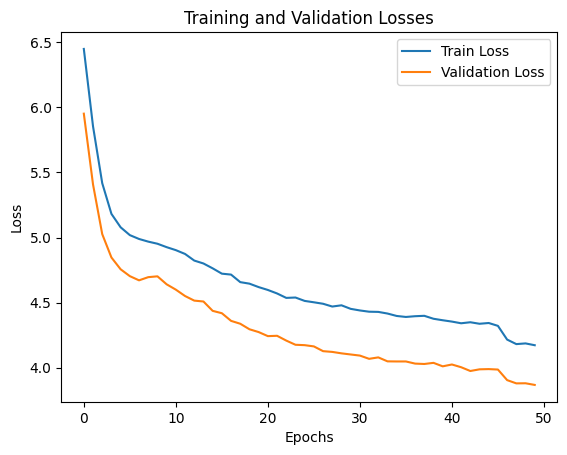

100%|██████████| 41/41 [00:05<00:00,  7.66it/s]


Test perplexity: 34.525401747923574


In [6]:
## Define the Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_LEN):
        super(PositionalEncoding, self).__init__()

        self.pe = torch.zeros(max_len, d_model)
        position_idx = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        denominator = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        self.pe[:, 0::2] = torch.sin(position_idx * denominator)
        self.pe[:, 1::2] = torch.cos(position_idx * denominator)

        self.pe = self.pe.unsqueeze(0).to(DEVICE)

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.pe.size(1):
            extra_pe = torch.zeros(seq_len - self.pe.size(1), self.pe.size(2), device=x.device)
            position_idx = torch.arange(self.pe.size(1), seq_len, dtype=torch.float).unsqueeze(1)
            denominator = torch.exp(torch.arange(0, self.pe.size(2), 2).float() * -(math.log(10000.0) / self.pe.size(2)))
            extra_pe[:, 0::2] = torch.sin(position_idx * denominator)
            extra_pe[:, 1::2] = torch.cos(position_idx * denominator)
            
            pe_extended = torch.cat([self.pe.squeeze(0), extra_pe], dim=0).unsqueeze(0)
        else:
            pe_extended = self.pe.to(x.device)
        return x + pe_extended[:, :seq_len, :]

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dropout=0.1):
        super(TransformerLM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)

        self.embedding_dropout = nn.Dropout(dropout/2)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, num_heads, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)

        self.fc_out.weight = self.embedding.weight

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, x, mask=None):
        batch_size, seq_len = x.size()

        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.embedding_dropout(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x, mask)

        logits = self.fc_out(x)
        return logits.view(batch_size, seq_len, -1), None


class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x)
        attention_output, _ = self.attention(x, x, x, mask=mask)
        x = x + self.dropout1(attention_output)

        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout2(ff_output)

        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.d_head = d_model // num_heads

        self.W_q, self.W_k, self.W_v = initialise_projections(d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        Q_proj = self.W_q(Q)
        K_proj = self.W_k(K)
        V_proj = self.W_v(V)

        Q_proj, K_proj, V_proj = split_heads_qkv(Q_proj, K_proj, V_proj, self.num_heads)

        attention_scores = pairwise_similarities(Q_proj, K_proj)
        attention_scores = attention_scaled(attention_scores)

        if mask is not None:
            attention_scores = apply_causal_mask(attention_scores, mask)

        attention_outputs, attention_weights = self_attention(attention_scores, V_proj)

        attention_outputs = merge_heads(attention_outputs, self.num_heads)

        outputs = self.W_o(attention_outputs)
        return outputs, attention_weights


## Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, tokenizer, tokenizer_inv, num_epochs=10):

    train_losses = []
    val_losses = []

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        val_loss = 0.0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            tokens = batch.to(DEVICE)
            X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

            seq_len = X_tokens.size(1)
            mask = make_causal_mask(seq_len).to(DEVICE)

            logits, _ = model(X_tokens, mask=mask)
            loss = criterion(logits.view(-1, logits.size(-1)), y_tokens.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                tokens = batch.to(DEVICE)
                X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()
                seq_len = X_tokens.size(1)
                
                mask = make_causal_mask(seq_len).to(DEVICE)
                logits, _ = model(X_tokens, mask=mask)
                loss = criterion(logits.view(-1, logits.size(-1)), y_tokens.view(-1))

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss}, Val Loss = {val_loss}")

        ## Generate a sample text
        sample_text = generate_text(model, tokenizer, tokenizer_inv, context="<START> I still have to ", gen_tokens=20)
        print(f"Sample text: {sample_text}")

        with open("/kaggle/input/shakesphere/shakespear_dev.txt", "r") as f:
            lines_test = f.readlines()

        test_losses = evaluate_losses(lines_test, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN)
        test_loss = np.mean(test_losses)
        perplexity = np.exp(test_loss)

        print(f"\nTest perplexity: {perplexity}")

    return train_losses, val_losses


def main():
    ## Load and preprocess data
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

    ## Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

    ## Model hyperparameters
    d_model = 512
    num_heads = 8
    num_layers = 6
    num_epochs = 50
    learning_rate = 0.001

    ## Initialize model
    model = TransformerLM(VOCAB_SIZE, d_model, num_heads, num_layers).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"])

    ## Print model summary
    print(model)

    ## Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, tokenizer, tokenizer_inv, num_epochs=num_epochs)

    ## Plot training and validation losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.show()

    ## Save the model
    torch.save(model.state_dict(), "transformer_lm.pth")
    with open("task1_tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)
    with open("task1_tokenizer_inv.pkl", "wb") as f:
        pickle.dump(tokenizer_inv, f)

    ## Evaluate on test data
    # with open("shakespear_test.txt", "r") as f:
    #     lines_test = f.readlines()

    with open("/kaggle/input/shakesphere/shakespear_dev.txt", "r") as f:
        lines_test = f.readlines()

    test_losses = evaluate_losses(lines_test, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN)
    test_loss = np.mean(test_losses)
    perplexity = np.exp(test_loss)

    print(f"\nTest perplexity: {perplexity}")

if __name__ == "__main__":
    main()

In [7]:
def inference(model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=10, temperature=0.6):
    ## Load the saved model
    model = TransformerLM(VOCAB_SIZE, 512, 8, 6).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    ## Read and process the input from test.txt
    with open(test_file, "r") as f:
        lines_test = f.readlines()

    model_loss = evaluate_losses(lines_test, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN)
    test_loss = np.mean(model_loss)
    perplexity = np.exp(test_loss)

    ## Generate text and calculate perplexity
    generated_texts = []
    for line in tqdm(lines_test, desc="Generating Text"):
        generated_text = generate_text(model, tokenizer, tokenizer_inv, context=line.strip(), gen_tokens=gen_tokens, temperature=temperature)
        generated_texts.append(generated_text)

    return generated_texts, perplexity


model_path = "transformer_lm.pth"
test_file = "/kaggle/input/shakesphere/shakespear_dev.txt"
tokenizer = pickle.load(open("task1_tokenizer.pkl", "rb"))
tokenizer_inv = pickle.load(open("task1_tokenizer_inv.pkl", "rb"))
generated_texts, ppl = inference(model_path, test_file, tokenizer, tokenizer_inv)
## Print the generated text and perplexity
for text in generated_texts:
    print(text)
print(f"Perplexity: {ppl}")

<ipython-input-7-15719a124934>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Generating Text: 100%|██████████| 1304/1304 [01

Nay , if there be no remedy for it , but that you will needs buy and sell men and women like beasts , we shall have all the world drink brown and white bastard . to the gentle and -- -- And in a jade
DUKE VINCENTIO : O heavens ! and the brother .
what stuff is here POMPEY : 'T was never merry world since , of two usuries , the merriest was put down , and the worser allowed by order of law a furred gown to keep him warm ; and furred with fox and lamb-skins too , to signify , that craft , being richer than innocency , stands for the facing . , To make a too , and I hear .
ELBOW : Come your way , sir . as as as I will hear by curst and to
'Bless you , good father friar . To see my and and call by the hour ?
DUKE VINCENTIO : And you , good brother father . ?
What offence hath this man made you , sir ? as I have have a word , And to do
ELBOW : Marry , sir , he hath offended the law : and , sir , we take him to be a thief too , sir ; for we have found upon him , sir , a strange picklock , wh